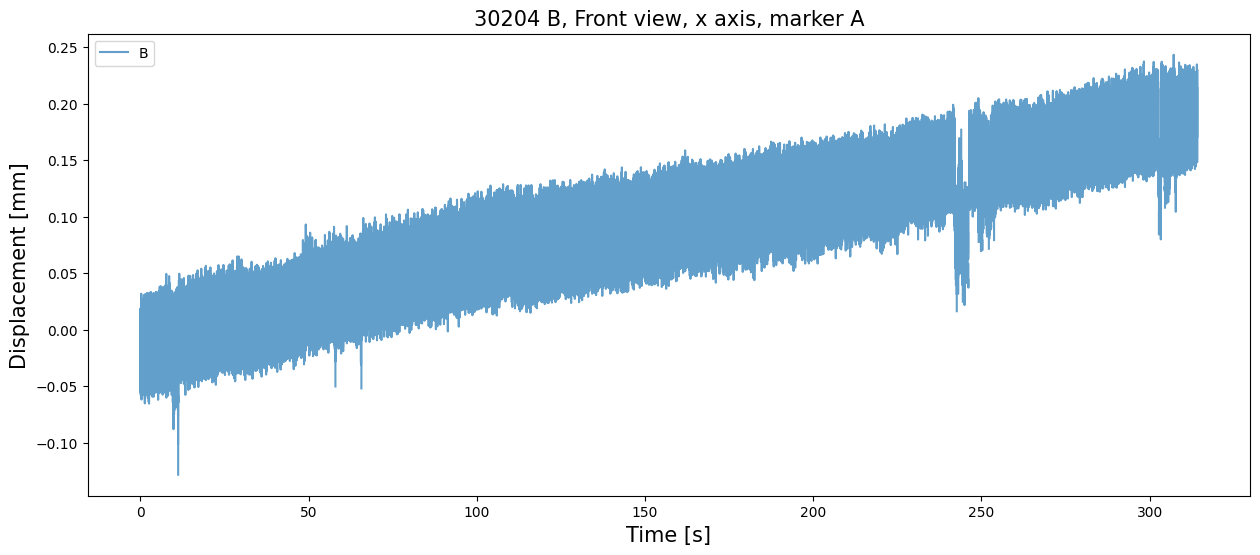

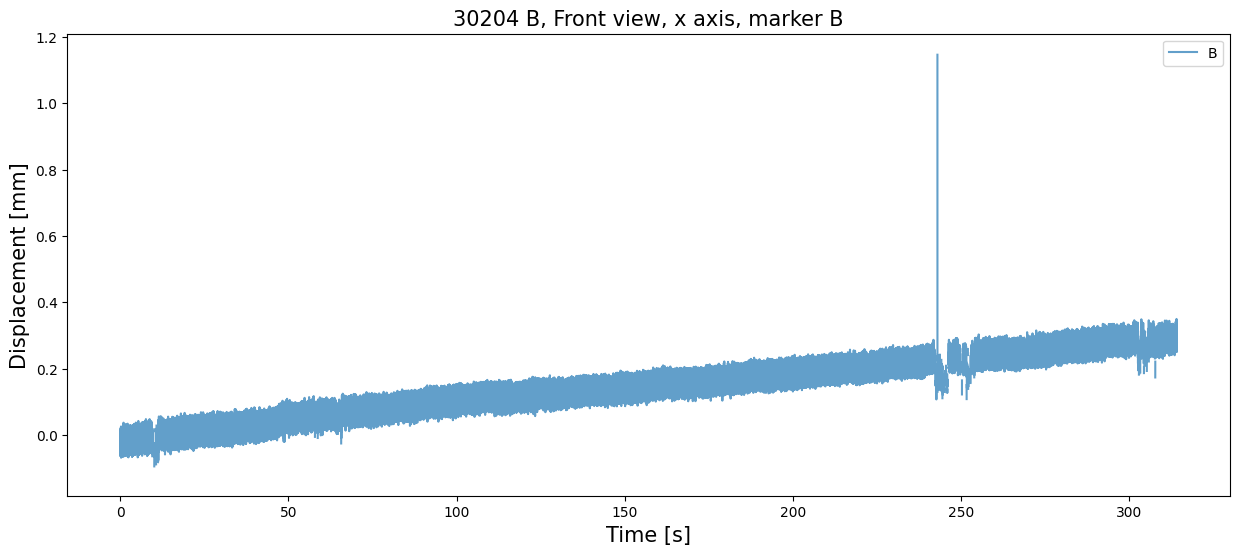

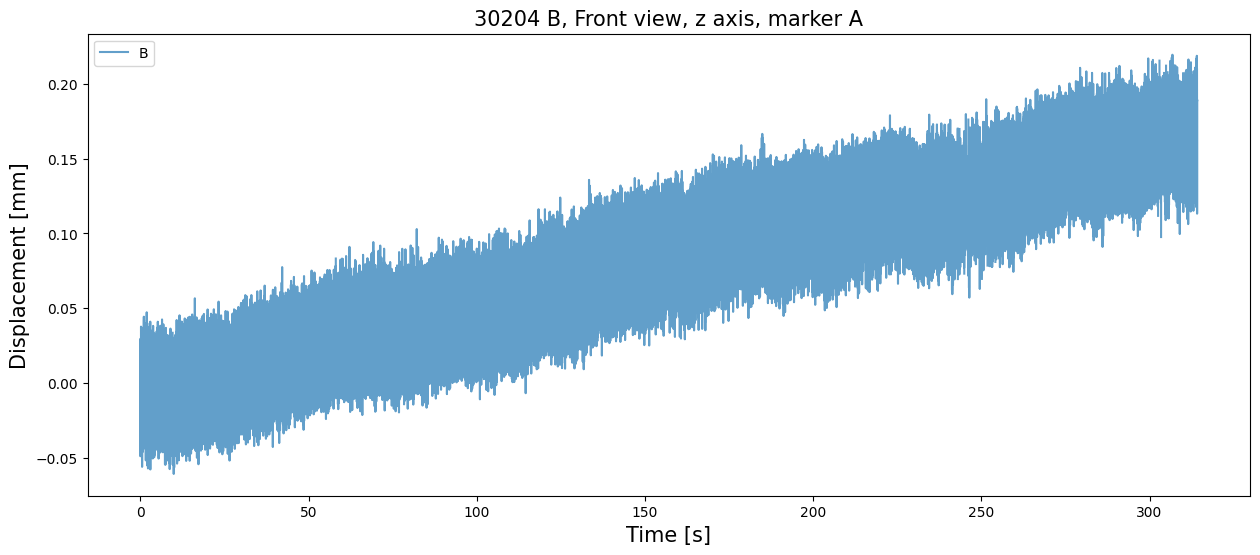

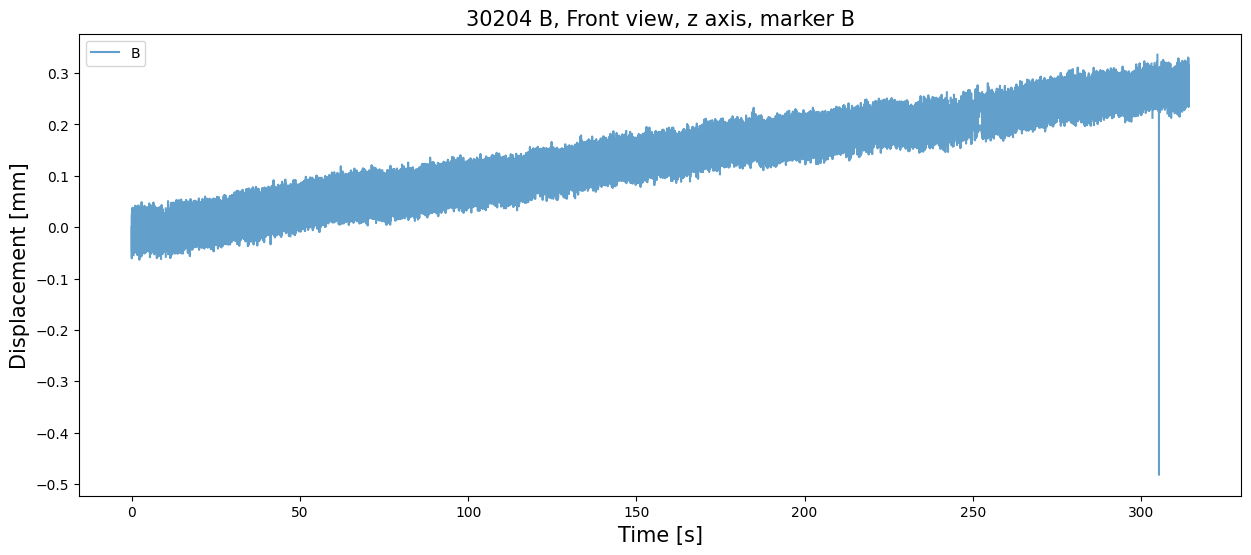

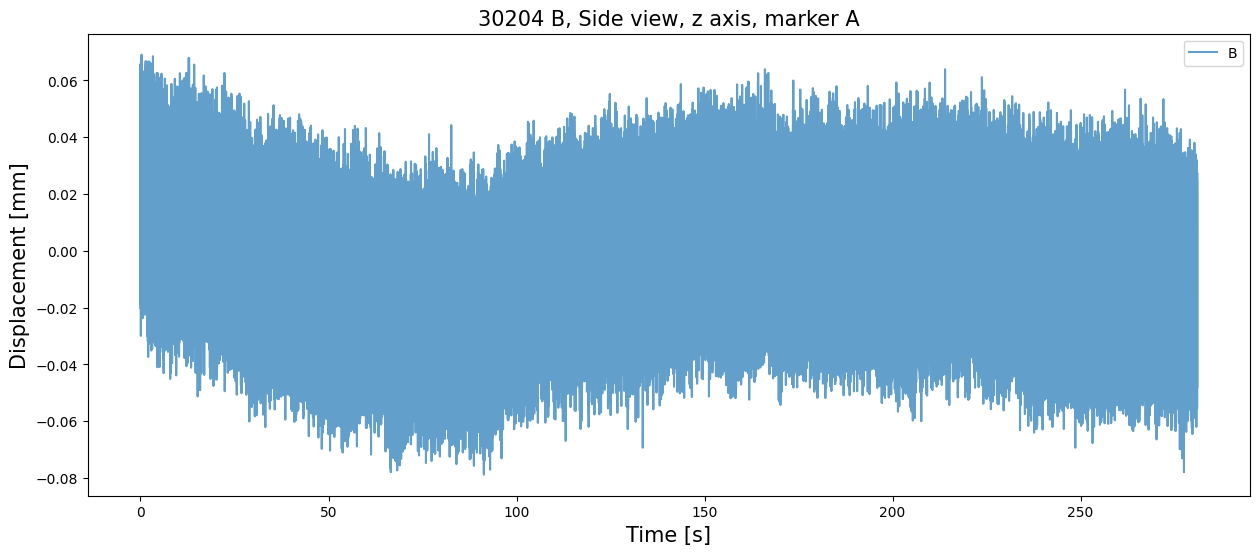

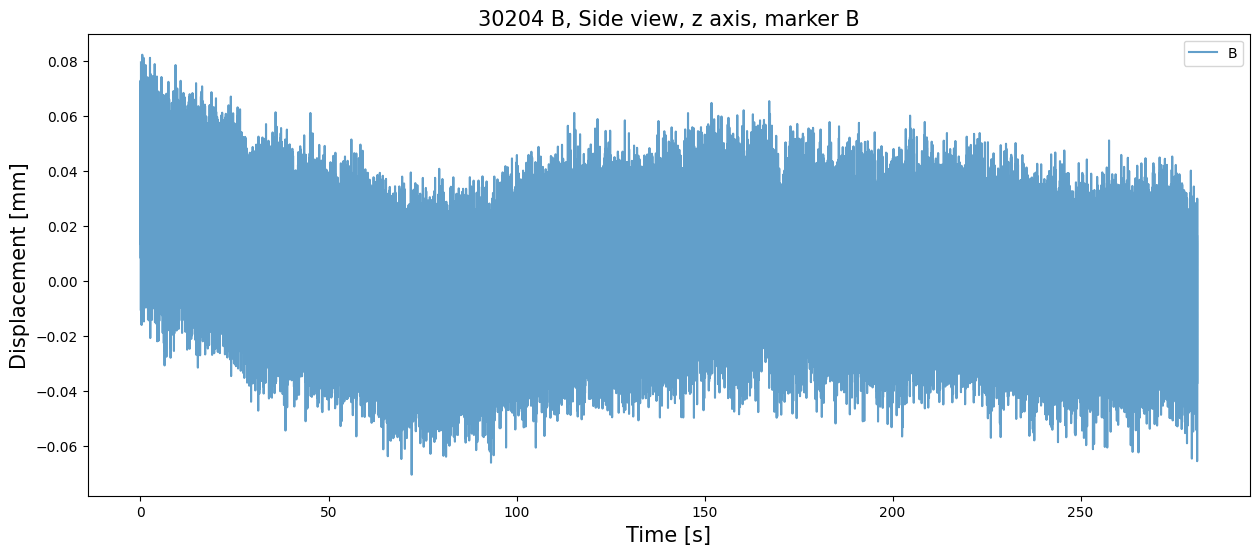

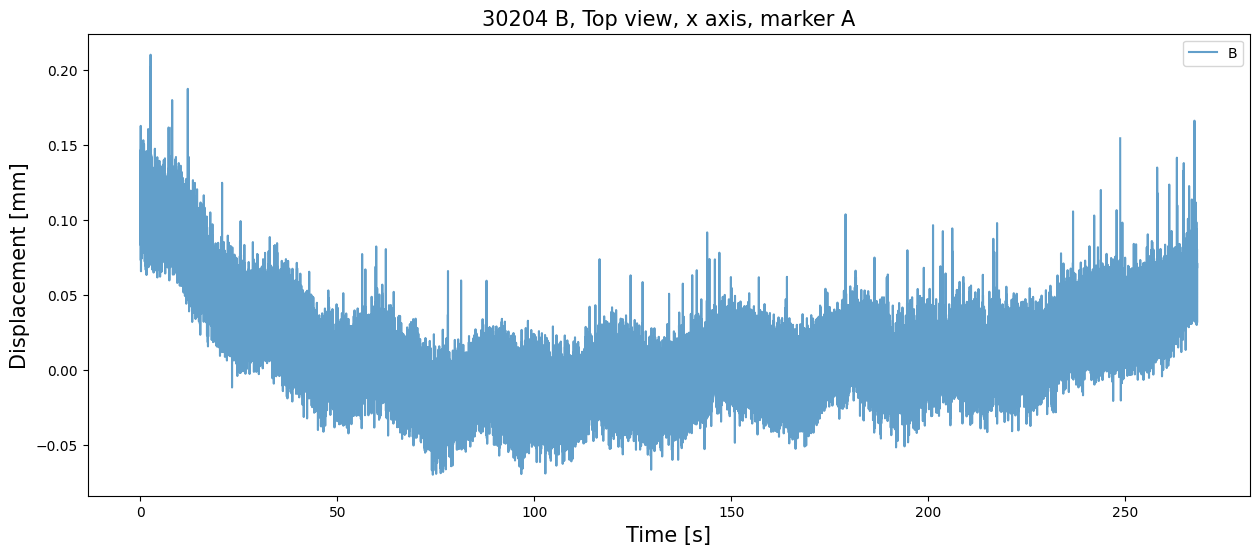

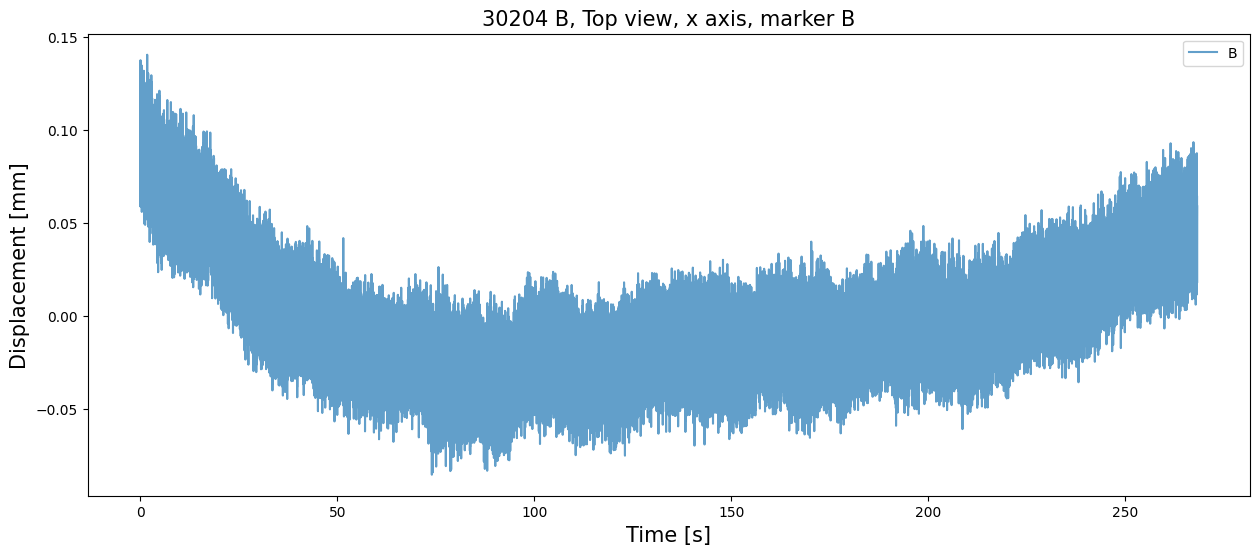

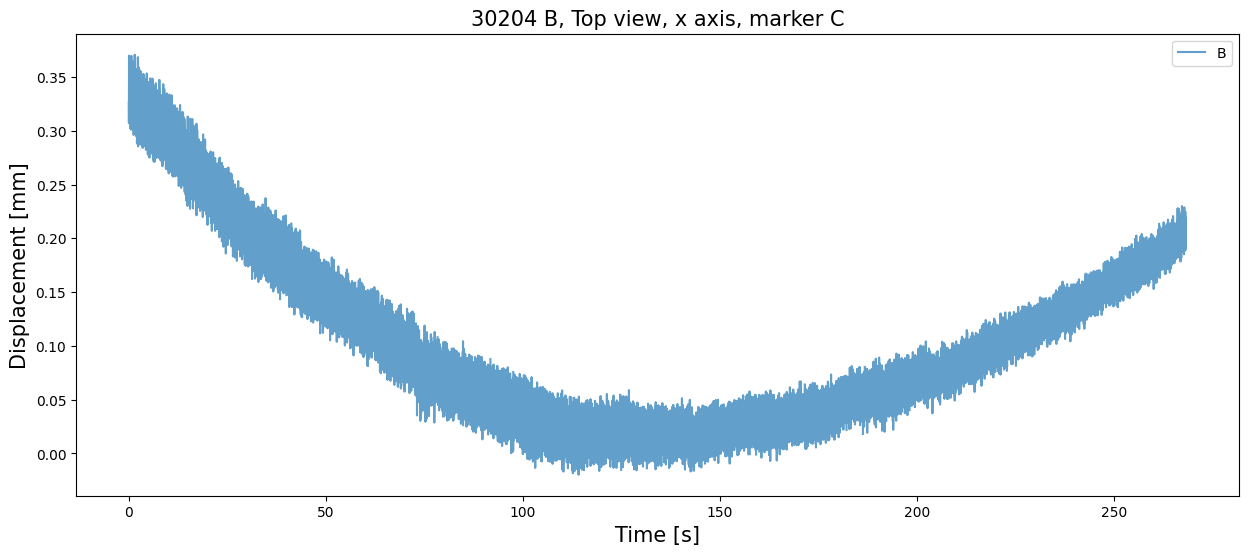

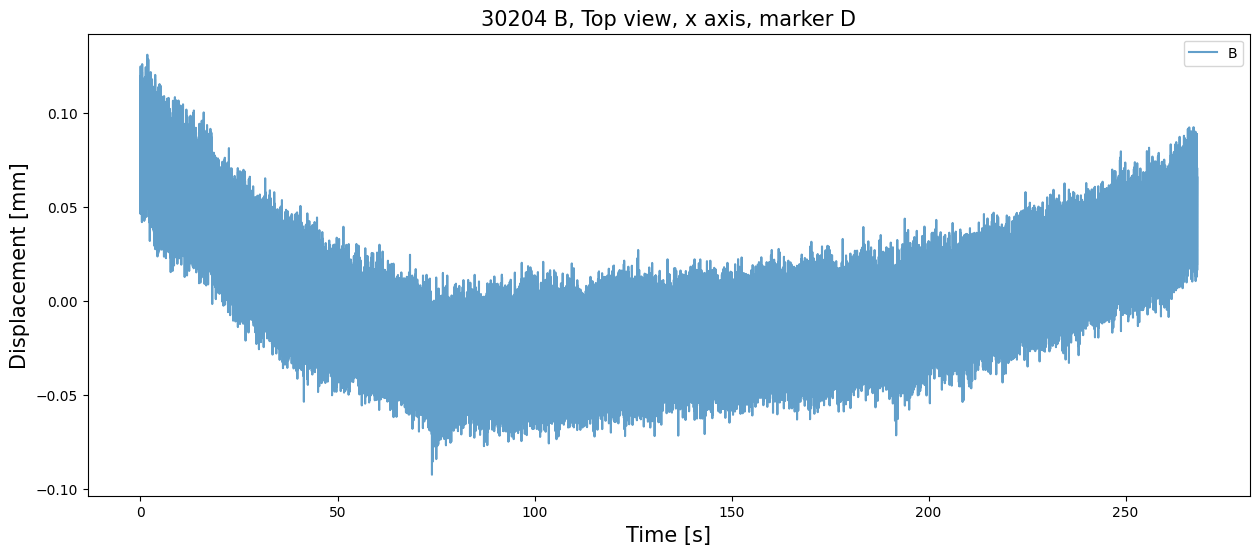

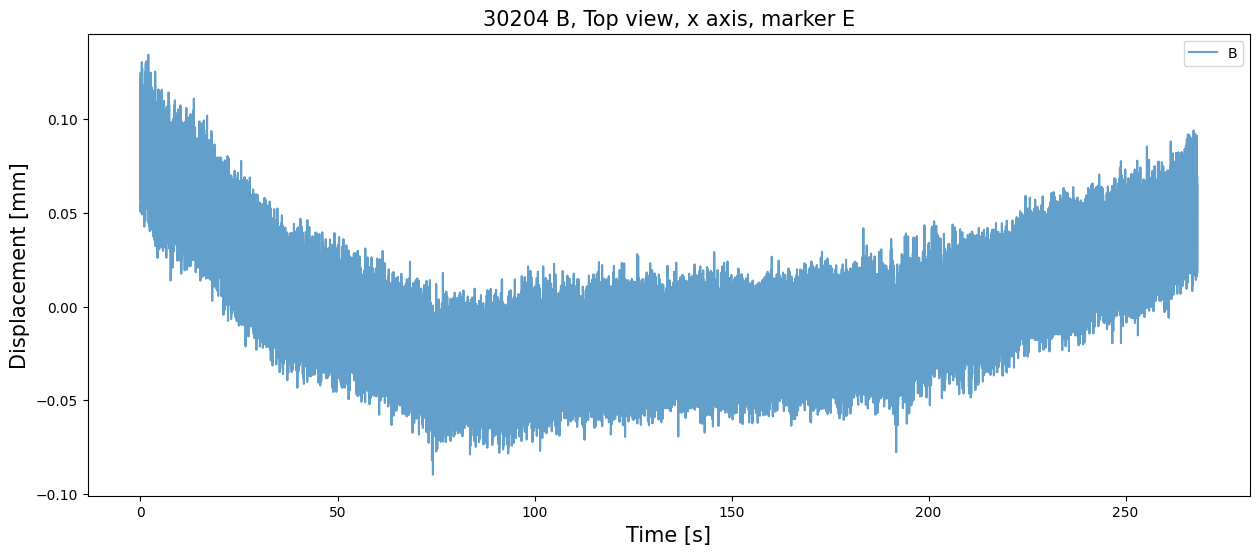

In [1]:
from funs import *

#####################################
# 그래프 보고자 하는 타겟 디렉토리 설정     
target_dir = '../output/0814'
######################################

dir_list = get_dir_list(target_dir, target_fault_type='B')
draw_single_graphs(dir_list, ['x.csv', 'z.csv'])